<a href="https://colab.research.google.com/github/satoshikawato/gbdraw/blob/main/gbdraw_interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title **1. Install gbdraw from GitHub repository**
%%time
import os

GBDRAW_READY = "GBDRAW_READY"

if not os.path.isfile(GBDRAW_READY):
    print("Cloning and installing gbdraw from GitHub...")
    if not os.path.isdir("gbdraw-main"):
        os.system("git clone https://github.com/satoshikawato/gbdraw.git gbdraw-main")

    os.chdir("gbdraw-main")
    os.system("pip install -q .")
    os.chdir("..")
    os.system(f"touch {GBDRAW_READY}")

print("Successfully installed")

Cloning and installing gbdraw from GitHub...
CPU times: user 110 ms, sys: 27.2 ms, total: 137 ms
Wall time: 25.6 s


Saving AB104413.gb to AB104413 (1).gb
✅ Uploaded successfully: AB104413_1.gb
🛠️ Command: gbdraw circular -i AB104413_1.gb -o gbdraw_output/AB104413_1 -f svg --track_type tuckin --show_labels --separate_strands -n GC -w 1000 -s 100 -k CDS,tRNA,rRNA,repeat_region --block_stroke_color black --block_stroke_width 0.0 --line_stroke_color gray --line_stroke_width 1.0 -l right 
📌 Result: AB104413_1.svg


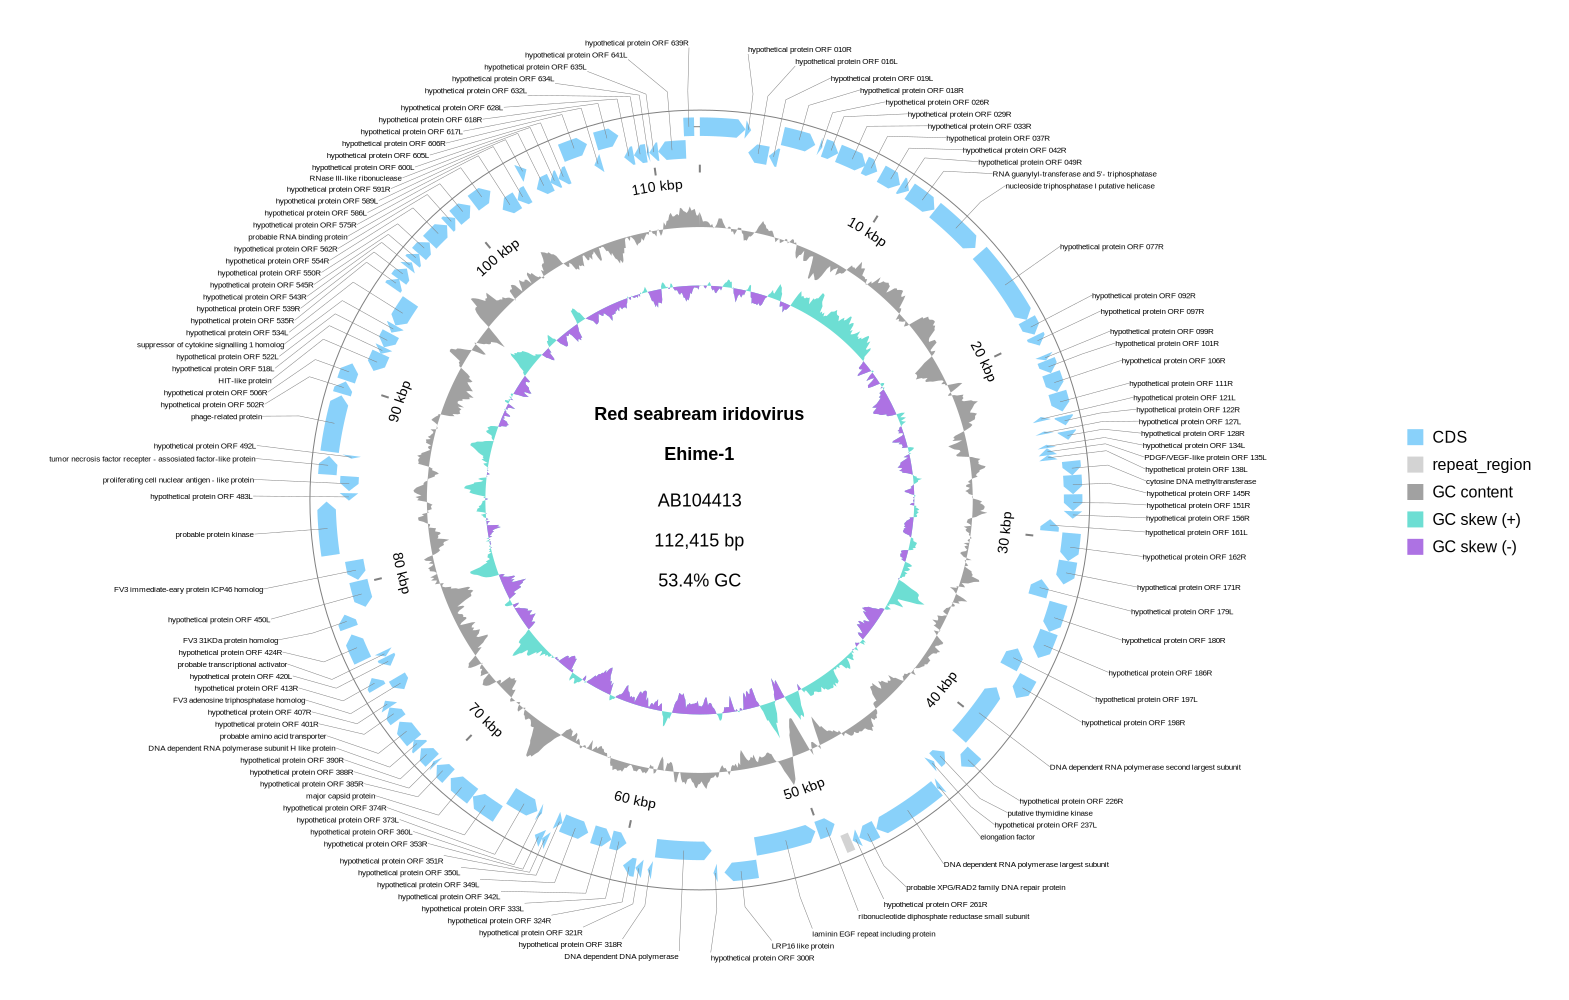

In [3]:
#@title 🚀 **2. Run gbdraw (circular)**
import os
import shutil
from IPython.display import display, Image, SVG, FileLink
from google.colab import files
import ipywidgets as widgets

# --- Global variables ---
uploaded_files: list[str] = []

output_dir = "gbdraw_output"
os.makedirs(output_dir, exist_ok=True)

# --- File upload button & dropdown ---
upload_btn = widgets.Button(description='📁 Upload a GenBank file')
file_dropdown = widgets.Dropdown(options=[], description='Select file:', disabled=True)

def upload_file(btn):
    global uploaded_files
    uploaded = files.upload()
    for orig_name in uploaded:
        safe_name = orig_name.replace(" ", "_").replace("(", "").replace(")", "")
        os.rename(orig_name, safe_name)
        if safe_name not in uploaded_files:
            uploaded_files.append(safe_name)
    file_dropdown.options = uploaded_files
    file_dropdown.disabled = False
    file_dropdown.value = uploaded_files[-1]
    print(f"✅ Uploaded successfully: {', '.join(uploaded_files)}")

upload_btn.on_click(upload_file)

# --- Basic setting panel ---
basic_box = widgets.VBox([
    widgets.HTML("<h3>Basic settings</h3>"),
    widgets.HBox([upload_btn, file_dropdown]),
    widgets.Dropdown(options=['tuckin', 'middle', 'spreadout'], value='tuckin', description='Track type:'),
    widgets.SelectMultiple(options=['svg', 'png'], value=['svg'], description='Output format:'),
    widgets.Checkbox(value=False, description='Show labels'),
    widgets.Checkbox(value=True, description='Separate strands'),
])

# --- Detailed setting panel ---
advanced_box = widgets.VBox([
    widgets.HTML("<h3>Detailed settings</h3>"),
    widgets.Text(value='GC', description='nt:'),
    widgets.IntText(value=1000, description='window:'),
    widgets.IntText(value=100, description='step:'),
    widgets.Text(value='', description='species:'),
    widgets.Text(value='', description='strain:'),
    widgets.Text(value='CDS,tRNA,rRNA,repeat_region', description='features:'),
    widgets.Text(value='black', description='block stroke color:'),
    widgets.FloatText(value=0, description='block stroke width:'),
    widgets.Text(value='gray', description='line stroke color:'),
    widgets.FloatText(value=1.0, description='line stroke width:'),
    widgets.Checkbox(value=False, description='Suppress GC track'),
    widgets.Checkbox(value=False, description='Suppress GC skew'),
    widgets.Dropdown(
        options=['right','left','upper_left','upper_right','lower_left','lower_right'],
        value='right', description='Legend position:'),
])
advanced_box.layout.display = 'none'

toggle_btn = widgets.ToggleButton(value=False, description='🔧 Display detailed settings')
def toggle_advanced(change):
    advanced_box.layout.display = None if change.new else 'none'
toggle_btn.observe(toggle_advanced, names='value')

# --- Run button ---
run_btn = widgets.Button(description='🚀 Run gbdraw', button_style='success')

def run_gbdraw(btn):
    if not uploaded_files:
        print("⚠️ Upload a GenBank file first.")
        return

    # --- ① 実行前のファイル更新時刻を取得 -----------------------------
    before_mtime = {
        f: os.path.getmtime(os.path.join(output_dir, f))
        for f in os.listdir(output_dir)
    }

    # --- ② コマンド生成 -------------------------------------------------
    gb_file      = file_dropdown.value
    track_type   = basic_box.children[2].value
    formats      = ','.join(basic_box.children[3].value)
    show_labels  = basic_box.children[4].value
    sep_strands  = basic_box.children[5].value
    output_prefix = gb_file.split('.')[0]

    cmd = (
        f"gbdraw circular -i {gb_file} -o {output_dir}/{output_prefix} "
        f"-f {formats} --track_type {track_type} "
    )
    if show_labels:
        cmd += "--show_labels "
    if sep_strands:
        cmd += "--separate_strands "

    if toggle_btn.value:
        (nt, window, step, species, strain, feats,
         blk_color, blk_width, line_color, line_width,
         sup_gc, sup_skew, legend) = [w.value for w in advanced_box.children[1:]]
        cmd += f"-n {nt} -w {window} -s {step} "
        if species: cmd += f"--species \"{species}\" "
        if strain:  cmd += f"--strain \"{strain}\" "
        cmd += (
            f"-k {feats} --block_stroke_color {blk_color} "
            f"--block_stroke_width {blk_width} "
            f"--line_stroke_color {line_color} "
            f"--line_stroke_width {line_width} "
        )
        if sup_gc:   cmd += "--suppress_gc "
        if sup_skew: cmd += "--suppress_skew "
        cmd += f"-l {legend} "

    print(f"🛠️ Command: {cmd}")
    os.system(cmd)

    # --- ③ 実行後のファイル更新時刻を取得 -----------------------------
    after_mtime = {
        f: os.path.getmtime(os.path.join(output_dir, f))
        for f in os.listdir(output_dir)
    }

    # --- ④ 新規作成 or 更新されたファイルを抽出 ------------------------
    changed_files = sorted(
        f for f, m in after_mtime.items()
        if f not in before_mtime or m > before_mtime[f] + 1e-6  # 1 µs 差分で更新判定
    )

    if not changed_files:
        print("⚠️ No new or updated output files found.")
        return

    # --- ⑤ 結果表示 -----------------------------------------------------
    for fname in changed_files:
        path = os.path.join(output_dir, fname)
        print(f"📌 Result: {fname}")
        if fname.lower().endswith('.png'):
            display(Image(filename=path))
        elif fname.lower().endswith('.svg'):
            display(SVG(filename=path))
        else:
            display(FileLink(path))

run_btn.on_click(run_gbdraw)

# --- UI display ---
ui = widgets.VBox([
    widgets.HTML("<h2>🧬 gbdraw: interactive UI</h2>"),
    basic_box,
    toggle_btn,
    advanced_box,
    run_btn
])
display(ui)
